###  Activity 1: All Possible Regressions

This is a quick assignment.  I would expect it to only take a couple of hours to complete. The start of this notebook develops the example.  You will then parallelize the exammple using `joblib`. 

Run this on a machine that has at least 4 cores. Typically this is your laptop. The ugrad machines are also OK. Google Colab is not adequate. Fill out the requested cells toward the bottom of the notebook.

**Due date**: September 16 1, 2022, 5:00 pm EDT.

**Instructions for Submission**: Submit via Gradescope.

#### Preparing the Environment

You will need a couple of packages installed to make this work.  Stop your instance of jupyter lab and then run

```
conda install pandas pandoc
jupyter lab
```
At this point, you should be ready to go.

#### Example code

This is a Python reimplementation of the Section 3.4. in _Matloff_, Parallel Computing for Data Science. It is based on data from https://www.kaggle.com/divan0/multiple-linear-regression. The notebook asks the question what combination of variables best predict the price of a house.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#importing dataset using panda
dataset = pd.read_csv('../data/kc_house_data.csv')
#to see what my dataset is comprised of
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
#dropping the id and date column
dataset = dataset.drop(['id','date'], axis = 1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

Let's first do a simple regression. How does square footage predict price? 

In [3]:
from sklearn.linear_model import LinearRegression

X = np.array(dataset.sqft_living)
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],1))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.4928817196006994


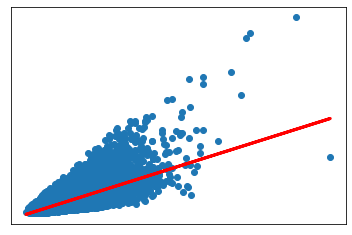

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# scatter data
plt.plot(X,Y,'o')
# best fit line
y_pred = model.intercept_ + model.coef_ * X
plt.plot(X, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

We see that there is a strong correlation between square footage and house price.  The coefficient of determination measures the strength of the correlation and varies between 0 (no correlation) and 1.0 (perfectly correlated).

### Multiple Linear Regression

Adding more variables often improves the score.

In [5]:
X = np.array(dataset[['sqft_living','condition','yr_built']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5249639858277426


but some variables are confounding

In [6]:
X = np.array(dataset[['zipcode','floors','waterfront']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.13588749977708703


This leads to a first parallel program.  What are the right set of variables? A brute force approach called _All Possible Regressions_ examines all combinations. So, let's build a big matrix that and we will regress on subsets.  We will look at all combinations of 1, 2, or 3 variables.

In [7]:
from itertools import combinations, chain

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(X.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

In [8]:
model = LinearRegression()

# do in a for loop (dumbest way)
r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo
    
print(r_sq_best, combo_best)

0.6095149101819036 (2, 6, 14)


The outcome is kind of crazy. The fields are `sqft-living`, `view`, and `latitude`. Latitude is probably a somewhat accurate proxy for wealth in this area, e.g. N of town richer than south of town. But, this is the kind of outcome that would not translate to other regions, i.e. is likely specific to this data.  _Neat_.

Back to performance.

In [9]:
%%timeit
model = LinearRegression()

r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo

922 ms ± 9.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see if flattening the loop matters. Replace for loop with a list comprehension of all combination of variables.

In [10]:
def r_sq_regression (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return model.score(Xp,Y)

In [11]:
%%timeit
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])

956 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It didn't seem to help. But, this is a step toward parallelization.

### Exercise (This is the assignment)

1. Use `joblib.Parallel` and `joblib.delayed` to parallelize the computation of the calls to `r_sq_regression`. <br>
    A. In one cell, print the answer to verify that your parallel program is correct.<br>
    B. In another cell time the computation. What is the speedup at `n_jobs=4`?<br>
    C. Estimate the Amdahl number for this computation. Show your work.<br>

In [12]:
import joblib

In [13]:
# TODO code for 1A
r_sq_list = joblib.Parallel(n_jobs=4)( joblib.delayed( r_sq_regression )( combo )
                                                                    for combo in combos
                                        )
r_sq_list = list(zip(combos, r_sq_list))

r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])
print(r_sq_arr[r_sq_idx])

[(2, 6, 14) 0.6095149101819038]


In [14]:
%%timeit 
# TODO code for 1B 
r_sq_list = joblib.Parallel(n_jobs=4)( joblib.delayed( r_sq_regression )( combo )
                                                                    for combo in combos
                                        )
r_sq_list = list(zip(combos, r_sq_list))

r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])

680 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**TODO Answer for 1B**<br>
1C. amdahl_number = 4/(4-1)*(1-1/4) = 1.0<br>
     --> 4 processors used and 4 jobs splited into

2. Use the batch size parameter to vary the number of jobs in each batch from 1,2,...128 @ n_jobs=4. You will need to look at the joblib documentation to read up about batch size.<br>
   A. Plot your results (use %timeit -o to capture output)<br>
   B. Model the problem as having two performance components: a fixed startup cost per batch ($C_B$) and perfect parallelism.  Estimate the batch startup cost (give a range).<br>
   C. Your answer to the batch startup costs should be noisy, i.e. there is not a consistent estimate for startup costs across all batch sizes. This indicates that a fixed startup cost per batch is not a good model. Consider other startup costs, such as skew, interference, and startup costs (per job). What do you think is a reasonable explanation for the inefficiency? What factors are possible?  Which factors can you eliminate?

In [124]:
# code for 2A
perf = []
for i in (2**p for p in range(8)):
    data = %timeit -o joblib.Parallel(n_jobs=4, batch_size=i)( joblib.delayed( r_sq_regression )( combo ) for combo in combos )
    perf.append([i, data.average])

1.05 s ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
801 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
637 ms ± 9.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
603 ms ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
521 ms ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
552 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
495 ms ± 5.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
504 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


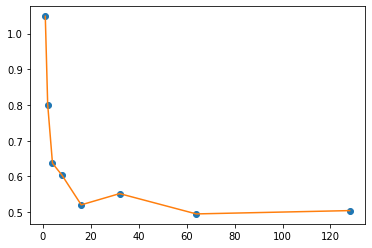

In [127]:
%matplotlib inline
# TODO plot for 2A
perf = np.array(perf)
# scatter data
plt.plot(perf[:, 0],perf[:, 1],'o')
plt.plot(perf[:, 0],perf[:, 1])

plt.show()

In [ ]:
# code for 2B
perf2 = pd.DataFrame(columns=[2**p for p in range(8)], index=[np.arange(1,7)])
for job in range(1, 7):
    for i in (2**p for p in range(8)):
        data = %timeit -o joblib.Parallel(n_jobs=job, batch_size=i)( joblib.delayed( r_sq_regression )( combo ) for combo in combos )
        perf2.loc[job, i] = data.average

In [154]:
# column = n_jobs, row = n_cpu
perf2

,1,2,4,8,16,32,64,128
1,1.113440,1.120619,1.095292,1.089747,1.104596,1.091846,1.097677,1.080648
2,1.526343,1.421301,1.214439,1.030140,0.991950,0.922856,0.894051,0.914231
3,1.152367,1.068295,0.864667,0.766737,0.698633,0.624596,0.603390,0.615698
4,1.137336,0.873536,0.711620,0.631421,0.598557,0.591054,0.571579,0.555627
5,1.049963,0.791993,0.658894,0.587233,0.567687,0.530652,0.550819,0.542458
6,1.075798,0.724549,0.578137,0.500634,0.455449,0.471147,0.503374,0.512305


In [163]:
print(f"range: {round(perf2.T.apply(lambda x: x.max() - x.min(), axis=1).min(), 2)}-{round(perf2.T.apply(lambda x: x.max() - x.min(), axis=1).max(), 2)}")

range: 0.48-0.7


**TODO Answer for 2B**<br>
The possible reason is that an overhead from splitting up the jobs to each thread can start to cost more once the number of thread gets bigger than number of cores due to less available memroy and cache.

3. Run the job with `prefer='threads'` and `prefer='processes'`. Given that `LinearRegression.fit()`. You do not need to vary batch size for this part.<br>
    A. Which is more efficient?  Why? Consider our discussion of parallel threads in python.<br>
    B. Can you conclude that `LinearRegression.fit()` does or does not release the GIL? Explain.<br>

_Note_: you can verify this conclusion by calling `LinearRegression.fit()` directly, rather than calling the wrapper functions `r_sq_regression`.

In [140]:
# Code for 3

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

model = LinearRegression()
print('threads',end=' ')
data = %timeit -o joblib.Parallel(n_jobs=4, prefer='threads')( joblib.delayed( model.fit )( X[:,combo],Y ) for combo in combos )

print('processes',end=' ')
data = %timeit -o joblib.Parallel(n_jobs=4, prefer='processes')( joblib.delayed( model.fit )( X[:,combo],Y ) for combo in combos )

# r_sq = model.score(X,Y)
# print('coefficient of determination:', r_sq)

threads 780 ms ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
processes 1.29 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**TODO Answer to 3**<br>
3A. Threading is more efficient because while processors wait on shared resources such as memory, threading requires less that it's more efficient.<br>
3B. if the GIL wasn't released, the time for each type should have been the same. However, we witnessed faster time for threads that the GIL seem to be released.